<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:
# Student 1: Gabriel Gomes Ziegler
# Student 2: Fabio D'Agostino
# Student 3: Levente Zolyómi

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
# notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# # UNCOMMENT IF USING COLAB
# from google.colab import drive
# import requests
# drive.mount('/content/drive')
# import sys
# import os
# sys.path.insert(0, notebook_dir) 
# os.chdir(notebook_dir)
# symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
# crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
# r_s = requests.get(symco, allow_redirects=True)
# r_c = requests.get(crpt, allow_redirects=True)
# with open('symconv.py', 'wb') as f:
#     f.write(r_s.content)
# with open('carpet.py', 'wb') as f:
#     f.write(r_c.content)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [2]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [3]:
# loading training and testing data for task 1
# DO NOT MODIFY
# task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test = y[9500:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")


Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Convolushahr


torch.Size([96, 60])

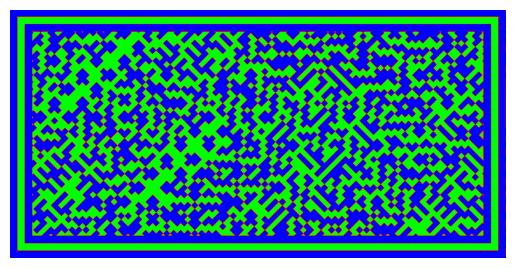

In [4]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])
X_train[idx, 0].shape

Taken from:

https://github.com/vlamen/tue-deeplearning/blob/main/tutorials/P2.1_CNN_classification_with_torch.nn.ipynb

In [5]:
def loss_batch(model, loss_func, xb, yb, opt=None):

    output = model(xb)
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.data)

    return loss.item(), corrects, len(xb)


In [7]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size)
test_dl = DataLoader(test_dataset, batch_size=batch_size)

In [18]:
train_dataset[0][0].shape

torch.Size([1, 96, 60])

# Vanilla CNN 

torch.Size([1, 96, 60])

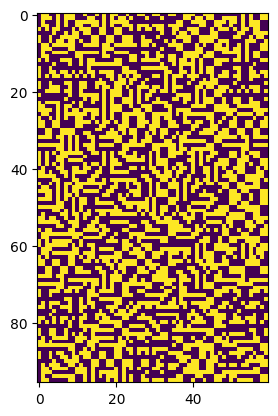

In [9]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[0][0].squeeze(0))
train_dataset[0][0].shape

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, n_classes=3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(18304, 256)
        # self.fc1 = nn.Linear(5005, 256)
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = torch.flatten(x, 1)

        # print(x.shape)

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)

        return x

In [11]:
from torch import optim
import torch.nn.functional as F
from datetime import datetime


def train_one_epoch(epoch_index, tb_writer, model, loss_func, opt, train_dl, val_dl):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dl):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        opt.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_func(outputs, labels)
        loss.backward()

        # Adjust learning weights
        opt.step()

        # Gather data and report
        running_loss += loss.item()

        if (i + 1) % (len(train_dl) // 4) == 0:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dl) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

def train(epochs, writer, model, loss_func, opt, train_dl, val_dl):
    # NOTE update this value
    best_vloss = 1_000_000

    for epoch_number in range(epochs):
        print('EPOCH {}:'.format(epoch_number + 1))
    
        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number, writer, model, loss_func, opt, train_dl, val_dl)
    
        # We don't need gradients on to do reporting
        model.train(False)
    
        running_vloss = 0.0
        for i, vdata in enumerate(val_dl):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_func(voutputs, vlabels)
            running_vloss += vloss
    
        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()
    
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            pass
            # NOTE Uncomment this to save your model
            # best_vloss = avg_vloss
            # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
            # torch.save(model.state_dict(), model_path)
    
        epoch_number += 1

In [12]:
from torch.utils.tensorboard import SummaryWriter

model = CNN()

loss_func = F.cross_entropy
opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Initializing in a separate cell so we can easily add more epochs to the same run
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

epochs = 10

train(epochs, writer, model, loss_func, opt, train_dl, val_dl)

EPOCH 1:
  batch 14 loss: 0.015411627054214477
  batch 28 loss: 0.01543004310131073


KeyboardInterrupt: 

# Convolutional Neural Networks

CNN using SymmetryPool, SymmetryConv2d and Slice.

In [15]:
from torch import nn
from symconv import Slice, SymmetryConv2d, SymmetryPool

# TODO Update values and functions here.
class SymmetryCNN(nn.Module):
    def __init__(self, n_classes=3):
        super(SymmetryCNN, self).__init__()
        self.conv1 = SymmetryConv2d(in_filters=1, out_filters=16, kernel_size=4, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)

        self.slice4 = Slice(rotation=4, reflection=False)

        self.relu = nn.ReLU()
        self.pool = SymmetryPool()

        self.fc1 = nn.Linear(5005, 256)
        # self.fc2 = nn.Linear(256, n_classes)
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.slice4(x)

        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)

        return x

In [16]:
model = SymmetryCNN()

loss_func = F.cross_entropy
opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Initializing in a separate cell so we can easily add more epochs to the same run
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epochs = 10

train(epochs, writer, model, loss_func, opt, train_dl, val_dl)

EPOCH 1:
  batch 14 loss: 0.017523479461669923
  batch 28 loss: 0.015839622259140016
  batch 42 loss: 0.015502905249595642


KeyboardInterrupt: 

In [ ]:
###     YOUR CODE FOR TASK 1    ###
### ADD MORE CELLS IF NECESSARY ###

## Task 1: Question 5d

# Task 2: Carpet Matching 

In [ ]:
# loading training and testing data for task 2
# DO NOT MODIFY
# task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [ ]:
# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):

        q = queries[i][None].float().cuda()
        t = targets[i].float().cuda()

        with torch.no_grad():
            
            
            ### MODIFY IF NECESSARY ###
            emb_q = net(q).cpu().numpy()
            emb_t = net(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)
            
            if top == 1:
                pred = np.argmin(dists)

                if pred == gt[i]:
                    cnt += 1
            
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0,:top].tolist():
                    cnt+=1
    return (100*cnt/gt.shape[0])

In [ ]:
###     YOUR CODE FOR TASK 2    ###
### ADD MORE CELLS IF NECESSARY ###